In [1]:
import sys
sys.path.append(r"../../utils")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.neural_network import MLPRegressor
from questionnaires_aggregation import c_ssrs_aggregation, sci_af_ac_aggregation
from utils import impute_from_column, simple_eda
from questions_columns import sci_af_ca, suicidal_behavior
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, max_error

In [2]:
# Splitting the data into train, validation, and test sets
train_ratio = 0.5
val_ratio = 0.3
test_ratio = 0.2
missing_sci_af_ca = [f'sci_af_ca_{i}' for i in range(26,41)]


In [3]:
df = pd.read_csv(r"../create_dataset/data_for_prediction_research.csv")
#df = df[df.age_child_pre > 11]
df_intake = df[df.measurement == 'time1']
df_target = df[df.measurement == 'time2']

In [4]:
print(f"# data in the original df = {df['id'].nunique()}\n")
print(f"# data in the df_target = {df_target['id'].nunique()}")
print(f"# data in the df_intake = {df_intake['id'].nunique()}")

merged_times = pd.merge(df_intake, df_target, on='id', how='inner')
print(f"# data in the merged_times = {merged_times['id'].nunique()}\n")


target_dropna = df_target.dropna(subset = suicidal_behavior, how='all')
print(f"# data in the df_target after removing missing data = {target_dropna['id'].nunique()}")

intake_dropna = df_intake.dropna(subset = sci_af_ca, thresh=20)
print(f"# data in the df_intake after removing missing data = {intake_dropna['id'].nunique()}")

merged_times_dropna = pd.merge(intake_dropna, target_dropna, on='id', how='inner')
print(f"# data in the merged_times after removing missing data = {merged_times_dropna['id'].nunique()}\n")

# data in the original df = 419

# data in the df_target = 329
# data in the df_intake = 408
# data in the merged_times = 318

# data in the df_target after removing missing data = 302
# data in the df_intake after removing missing data = 237
# data in the merged_times after removing missing data = 174



In [5]:
df_target = df_target.dropna(subset= suicidal_behavior, how='all')#df_target.dropna(subset=suicidal_behavior, how='all')
df_target['label'] = (df_target[suicidal_behavior].sum(axis=1) > 0).astype(int)
df_target = df_target[['label', 'id'] + suicidal_behavior]

df_intake = df_intake.dropna(subset=sci_af_ca, thresh=20)
df_intake, sci_af_ac_factors = sci_af_ac_aggregation(df_intake)
df_intake['missing_sci_af_ca'] = df_intake[missing_sci_af_ca].isna().all(axis=1)
df_intake = df_intake[sci_af_ca + sci_af_ac_factors + ['missing_sci_af_ca', 'id']]


data_for_prediction = pd.merge(df_intake, df_target, on='id', how='inner')
print(f"{data_for_prediction['id'].nunique() = }")

data_for_prediction['id'].nunique() = 174


In [6]:
eda = True
if eda:
    simple_eda(data_for_prediction, columns = list(data_for_prediction.columns), title = 'suicidal behivior prediction based on sci_af_ac', display_additional_columns=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
features = data_for_prediction[sci_af_ca + sci_af_ac_factors + ['missing_sci_af_ca']]
label = data_for_prediction['label']
print(f"N features = {features.shape}\n{label.count() = }\n{label.sum() = }")
print(f"pos ratio  = {(label.count() - label.sum())/ label.sum() } ")

N features = (174, 46)
label.count() = 174
label.sum() = 34
pos ratio  = 4.117647058823529 


<AxesSubplot:>

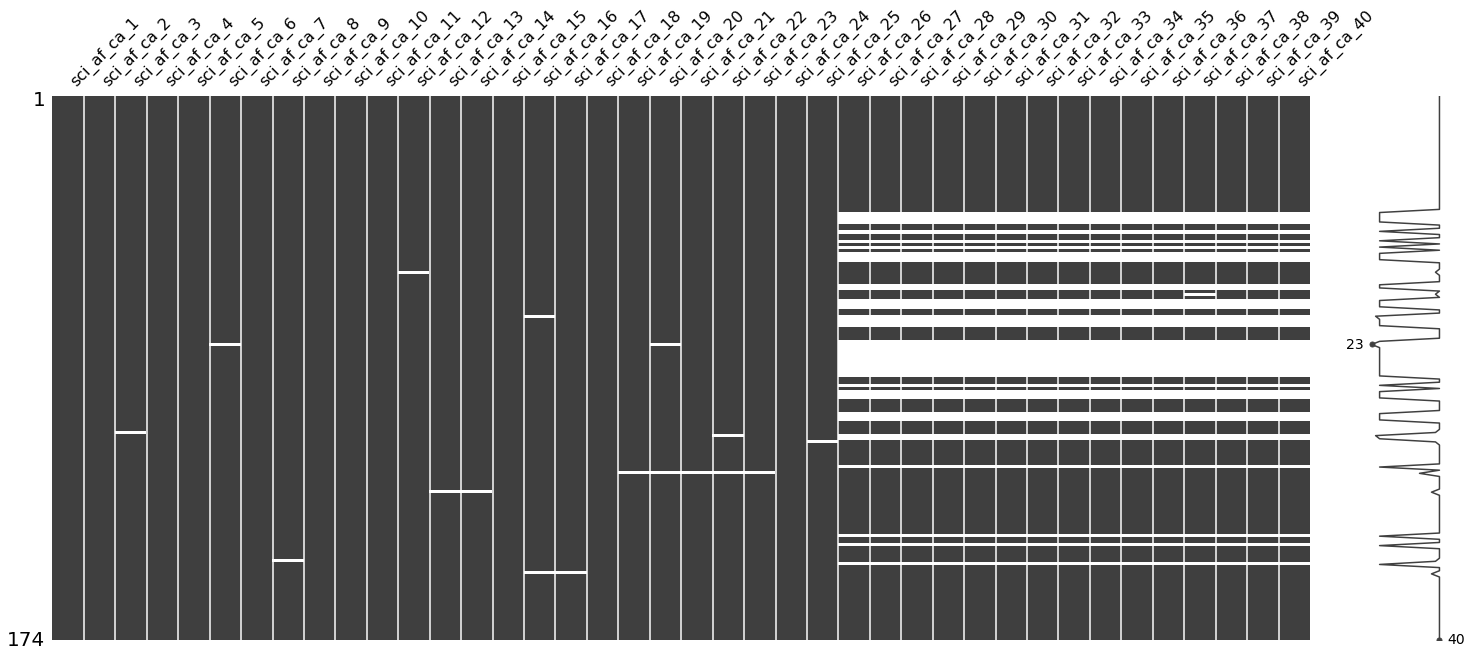

In [31]:
msno.matrix(data_for_prediction[sci_af_ca])

In [9]:

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=test_ratio, random_state=42, stratify=label)

# Splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio/(train_ratio+val_ratio), random_state=42, stratify=y_train)

In [10]:
"""model = CatBoostClassifier(random_state=42, depth = 6, l2_leaf_reg = 10, auto_class_weights = 'Balanced',
                           langevin = True, score_function = 'L2', model_size_reg = 1.0, boosting_type = 'Ordered',
                           eval_metric='Precision', approx_on_full_history = True, eta=0.005,
                          random_strength = 2, n_estimators=100)"""


"model = CatBoostClassifier(random_state=42, depth = 6, l2_leaf_reg = 10, auto_class_weights = 'Balanced',\n                           langevin = True, score_function = 'L2', model_size_reg = 1.0, boosting_type = 'Ordered',\n                           eval_metric='Precision', approx_on_full_history = True, eta=0.005,\n                          random_strength = 2, n_estimators=100)"

In [26]:
eval_set  = [(X_val, y_val)]
# model = CatBoostClassifier(random_state=42, l2_leaf_reg = 9, auto_class_weights = 'Balanced',
#                            model_size_reg = 1.0, eval_metric='Precision', random_strength = 3)

# # Fit the model on the training set
# model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=2)
model = XGBClassifier(random_state=42, reg_lambda=9, scale_pos_weight=4,
                      max_delta_step=1.0, eval_metric='aucpr')
model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=2)

# Make predictions on the training and validation sets
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]

y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]


[0]	validation_0-aucpr:0.36404
[1]	validation_0-aucpr:0.37810
[2]	validation_0-aucpr:0.42590
[3]	validation_0-aucpr:0.33412
[4]	validation_0-aucpr:0.36875


C:\Users\nogur\anaconda3\envs\DeppClinic\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [27]:
# Function to calculate and print various performance metrics

def print_performance_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    average_precision = average_precision_score(y_true, y_prob)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'PR AUC: {average_precision:.4f}')


In [28]:
# Print the performance metrics for the training set
print('Training set performance:')
print_performance_metrics(y_train, y_train_pred, y_train_prob)



Training set performance:
Accuracy: 0.9186
Precision: 0.7273
Recall: 0.9412
ROC AUC: 0.9706
PR AUC: 0.9324


In [29]:
# Print the performance metrics for the validation set
print('Validation set performance:')
print_performance_metrics(y_val, y_val_pred, y_val_prob)


Validation set performance:
Accuracy: 0.7170
Precision: 0.3529
Recall: 0.6000
ROC AUC: 0.6965
PR AUC: 0.4343


In [30]:

# Get feature importance scores
feature_importance = model.get_feature_importance()
feature_names = X_train.columns.tolist()
# Print feature importance scores
print('Feature importance scores:')
for feature_name, score in sorted(zip(feature_names, feature_importance), reverse=1, key = lambda x: x[1]):
    print(f'{feature_name}: {score:.4f}')

AttributeError: 'XGBClassifier' object has no attribute 'get_feature_importance'

cool, 
use the train-validation-test variables that you created in the last snippet, 
and train CatBoostClassifier, with early_stopping parameter based on the validation set.

after that look at the performance scores on the training & validation sets.
and the feature-importance scores

Since it's a complicated task, we need to use the following metrics: accuracy, precision, recall, precision-recall-auc, roc_auc

#### Create a CatBoostClassifier object with early stopping based on the validation set
eval_set  = [(X_val, y_val)]
#model = CatBoostClassifier(random_state=42, depth = 5, l2_leaf_reg = 7, loss_function='CrossEntropy', eval_metric='AUC')
model = CatBoostClassifier(random_state=42, depth = 2, l2_leaf_reg = 10, class_weights = [1, 8], eval_metric='Precision')

##### Fit the model on the training set
model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds = 5)#, eval_set=(X_val, y_val))


#### Make predictions on the training and validation sets
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]

y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]


eval_set  = [(X_val, y_val)]
model = CatBoostClassifier(random_state=4212, depth = 6, l2_leaf_reg = 10, auto_class_weights = 'Balanced',
                           langevin = True, score_function = 'L2', model_size_reg = 1.0, boosting_type = 'Ordered',
                           eval_metric='CrossEntropy', od_pval = 10**-2, od_wait=5, approx_on_full_history = True,
                          random_strength = 2, leaf_estimation_iterations=2)

# Fit the model on the training set
model.fit(X_train, y_train, eval_set=eval_set)#, eval_set=(X_val, y_val))


# Make predictions on the training and validation sets
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]

y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]
